### Feature_importance 확인
1. RandomForestRegressor 이용한 주요 변수 확인
---


In [1]:
#패키지 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import configparser

In [2]:
#Config 불러오기

config_file ='C:/Workspace/temp_test/Config/config.ini'
config = configparser.ConfigParser()
config.read(config_file, encoding='utf-8')

# Data Preprocessing Configuration
path_data = config['DATAPREPROCESSING']['PATH_DATA'] 
Target_col = config['DATAPREPROCESSING']['TARGET_COL'] 
Categorical_col_list = config['DATAPREPROCESSING']['CATEGORICAL_COL']
Numeric_col_list = config['DATAPREPROCESSING']['NUMERIC_COL']

# Data Scaling Configuration
scaler_type = config['DATASCALING']['SCALER_TYPE']

In [3]:
# seaborn의 내장 데이터셋인 'tips' 데이터
data = pd.read_csv(path_data)
X = data.drop(columns=['tip'])
y = data['tip']

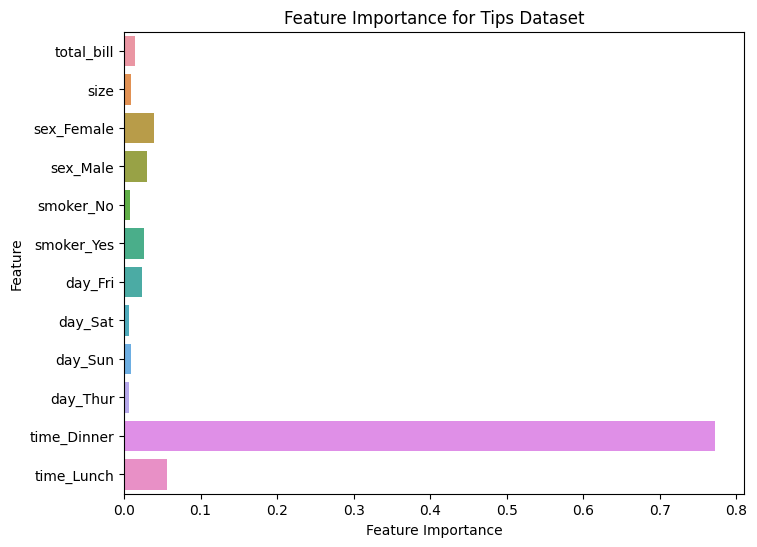

In [13]:
# 범주형 변수를 더미 변수로 변환하는 파이프라인 생성

Numeric_col = [value.strip() for value in Numeric_col_list.split(',')]
Categorical_col = [value.strip() for value in Categorical_col_list.split(',')]
        
categorical_columns = Categorical_col
numeric_columns = Numeric_col
 
if scaler_type == 'standard':
    scaler = StandardScaler()
elif scaler_type == 'min_max':
    scaler = MinMaxScaler()
elif scaler_type == 'robust':
    scaler = RobustScaler()
else:
    raise ValueError("Invalid scaler_type. Choose from 'standard', 'min_max', or 'robust'.")
        
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ('num', scaler, numeric_columns)
    ])

# RandomForestRegressor 모델 생성
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# 전처리와 모델 훈련을 포함한 파이프라인 생성
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# 모델 훈련
model.fit(X, y)

# 주요 변수 추출
if hasattr(model.named_steps['regressor'], 'feature_importances_'):
    feature_importances = model.named_steps['regressor'].feature_importances_
else:
    feature_importances = None

# 주요 변수 시각화
if feature_importances is not None:
    
    # 범주형 변수의 더미 변수 이름 가져오기
    cat_onehot_features = model.named_steps['preprocessor'].transformers_[0][1]['onehot'].get_feature_names_out(input_features=categorical_columns)
    
    # 모든 특성의 이름 가져오기
    all_feature_names = numeric_columns + cat_onehot_features.tolist()
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=feature_importances, y=all_feature_names)
    plt.title('Feature Importance for Tips Dataset')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("Feature importances are not available for the chosen model.")
